# UBC-MDS/DSCI_522_group_401
# Predicting Medical Insurance Cost
Authors: Karanpal Singh, Sreejith Munthikodu, Sirine Chahma  
[Data Source](https://gist.github.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split

### Load the data

In [2]:
medical_data = pd.read_csv("../data/processed/medical_cost_data_train.csv")
medical_data.head()

,age,sex,bmi,children,smoker,region,charges
0,64,female,22.990,0,yes,southeast,27037.91410
1,51,male,31.635,0,no,northwest,9174.13565
2,31,female,30.495,3,no,northeast,6113.23105
3,48,female,22.800,0,no,southwest,8269.04400
4,23,male,24.510,0,no,northeast,2396.09590


In [3]:
X_train = medical_data.drop(columns = "charges")
X_train.head()

,age,sex,bmi,children,smoker,region
0,64,female,22.990,0,yes,southeast
1,51,male,31.635,0,no,northwest
2,31,female,30.495,3,no,northeast
3,48,female,22.800,0,no,southwest
4,23,male,24.510,0,no,northeast


In [4]:
y_train = medical_data[["charges"]]
y_train.head()

,charges
0,27037.91410
1,9174.13565
2,6113.23105
3,8269.04400
4,2396.09590


In [5]:
print(f"Total number of train samples: {medical_data.shape[0]}")

Total number of train samples: 936


# Exploratory Data Analysis 

### Basic preprocessing

In [6]:
X_train.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
dtype: object

In [7]:
# Check for missing values
X_train.isna().any().any()

False

There are no missing values in our data

In [8]:
# Identify categoric and numeric features
data_types = X_train.dtypes
categoric_features = []
numeric_features = []
for d_type, feature in zip(data_types, data_types.index):
    if d_type == "object":
        categoric_features.append(feature)
    else:
        numeric_features.append(feature)

numeric_features = numeric_features
print(f"Numeric features are: {numeric_features}")
print(f"Categoric features are: {categoric_features}")

Numeric features are: ['age', 'bmi', 'children']
Categoric features are: ['sex', 'smoker', 'region']


In [9]:
# Explore cardinality in categoric features
print(f"Total samples: {X_train.shape[0]}")
for cat_feature in categoric_features:
    print(f"Number of unique values in {cat_feature} is {X_train[cat_feature].nunique()}")

Total samples: 936
Number of unique values in sex is 2
Number of unique values in smoker is 2
Number of unique values in region is 4


In [10]:
# Detect outliers in numeric features

def detect_outlier(x):
    """
    Detect outliers from the given array using inter-quartile range. 
    Considered an outlier if value is less than Q1 - 1.5 IQR or
    Q2 + 1.5 IQR
    
    Parameters
    ----------
    x : list, array-like
        input array of numbers

    Returns
    -------
    tuple
        tuple containing indices of the outliers and outliers 

    """
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    ceil =  Q3 + 1.5*IQR
    floor = Q1 - 1.5*IQR
    outlier_index = x.index[(x < floor) | (x > ceil)]
    outliers = x[outlier_index]
    
    return outlier_index, outliers

outliers = {}
for col in numeric_features:
    outlier_index, outliers = detect_outlier(X_train[col])
    outliers[col] = outlier_index
    print(f"Total outliers in {col} is {len(outliers)}")
    

Total outliers in age is 1
Total outliers in bmi is 9
Total outliers in children is 1


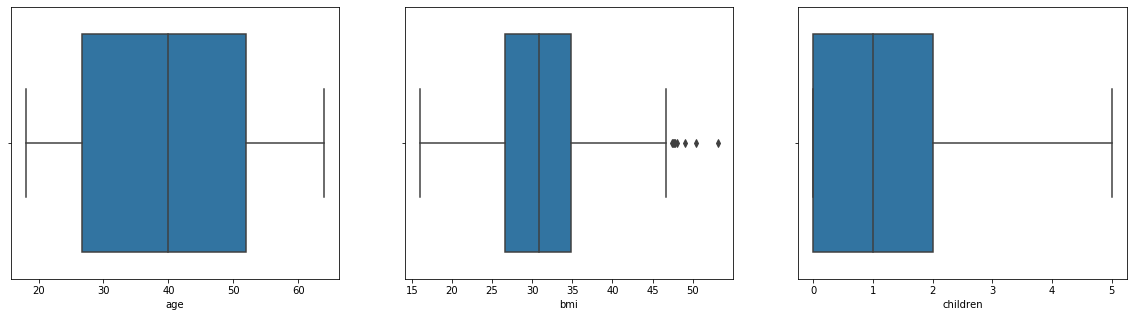

In [11]:
# Visualize the distribution using boxplot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axes = ax.reshape(-1)
for col, ax in zip(numeric_features, axes):
    sns.boxplot(col,  data = X_train, ax = ax)

In [12]:
X_train.describe()


,age,bmi,children
count,936.000000,936.000000,936.000000
mean,39.337607,30.868691,1.083333
std,14.130761,6.022251,1.210250
min,18.000000,15.960000,0.000000
25%,26.750000,26.600000,0.000000
50%,40.000000,30.800000,1.000000
75%,52.000000,34.800000,2.000000
max,64.000000,53.130000,5.000000


When we look at the scope of the numerical features, we realize that all the values belong to a plausible range. Even though our previous analysis reveled some extreme values, we are going to keep those values because they corresponds to a rare situation that could occur, they are not related to an error in the measurement.

In [233]:
#Detect the correlation between the features

cor = medical_data.corr().reset_index()
cor = pd.melt(cor, id_vars="index")

In [234]:
cor = cor.replace([1], [None])


In [235]:
cor

,index,variable,value
0,age,age,None
1,bmi,age,0.113401
2,children,age,0.0660198
3,charges,age,0.286005
4,age,bmi,0.113401
5,bmi,bmi,None
6,children,bmi,0.0153649
7,charges,bmi,0.177589
8,age,children,0.0660198
9,bmi,children,0.0153649


In [236]:
#Set as None the values that we find twice in the correlation table

ind={}

for i in range(cor.shape[0]):
    for elem in ind:
        if cor['variable'][i] in ind[elem]:
            if cor['index'][i] == elem:
                cor.loc[[i], ['value']] = None
    if cor['variable'][i] in ind :
            ind[cor['variable'][i]].append(cor['index'][i])
    else : 
        ind[cor['variable'][i]] = []

cor

,index,variable,value
0,age,age,None
1,bmi,age,0.113401
2,children,age,0.0660198
3,charges,age,0.286005
4,age,bmi,None
5,bmi,bmi,None
6,children,bmi,0.0153649
7,charges,bmi,0.177589
8,age,children,None
9,bmi,children,None


In [237]:
cor.loc[[14], ['value']] = cor['value'][11]
cor.loc[[11], ['value']] = None

In [239]:
heatmap=alt.Chart(cor).mark_rect().encode(
    alt.X('index:O', title=''),
    alt.Y('variable:O', title=''),
    alt.Color('value:Q',scale = alt.Scale(domain=[0, 1], scheme = 'purplered'))
).properties(title="Correlation map of the features",
            width = 300,
            height = 300
)

We can see that the numerical features don't seem to be correlated. 

In [240]:
text = heatmap.mark_text(baseline='middle', fontSize=20).encode(
    text=alt.Text('value:Q', format='.2'),
    color=alt.condition(
        alt.datum.Correlation >= 0.95,
        alt.value('black'),
        alt.value('white')
    )
)
corrMatrix_chart = (heatmap + text)

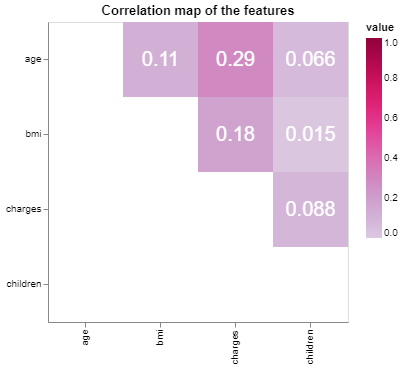

In [241]:
corrMatrix_chart

### Exploring features

**Let's see if medical expenses tend to change with the age of a person**

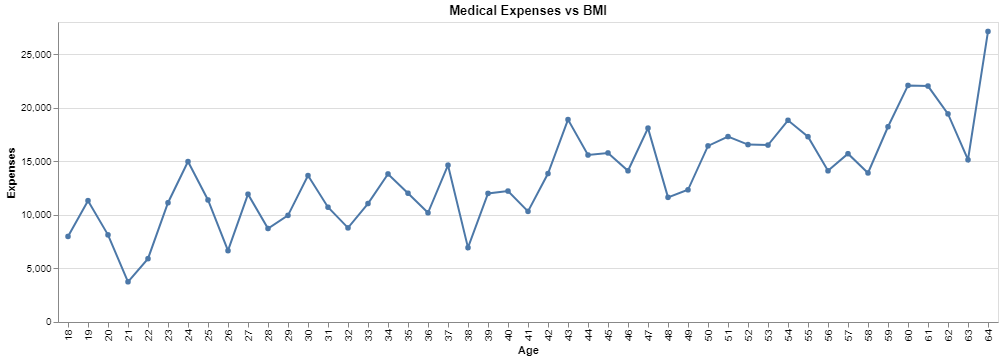

In [16]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['age']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Expenses')
).properties(title='Medical Expenses vs BMI')

The charges seem to increase when the age of a person increases. There is a peak in the expenses at the age of 43.

**Let's see if medical expenses tend to change with the BMI of a person**

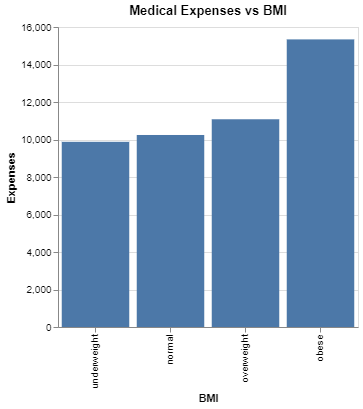

In [17]:
training_df = X_train
training_df['charges'] = y_train

training_df['bmi_cat'] = 'normal'
training_df.loc[training_df['bmi'] < 18.5,'bmi_cat'] = 'underweight'
training_df.loc[training_df['bmi'] > 25,'bmi_cat'] = 'overweight'
training_df.loc[training_df['bmi'] > 30,'bmi_cat'] = 'obese'


alt.Chart(training_df.groupby(['bmi_cat']).mean().reset_index()).mark_bar().encode(
    alt.X('bmi_cat', title = 'BMI', sort=['underweight', 'normal', 'overweight', 'obese']),
    alt.Y('charges:Q', title = 'Expenses')
).properties(title='Medical Expenses vs BMI', width=300)

The highest expenses seem to occur for people who are obese. 

**Let's see how much money males and females spending for medical treatments during their lifetime**

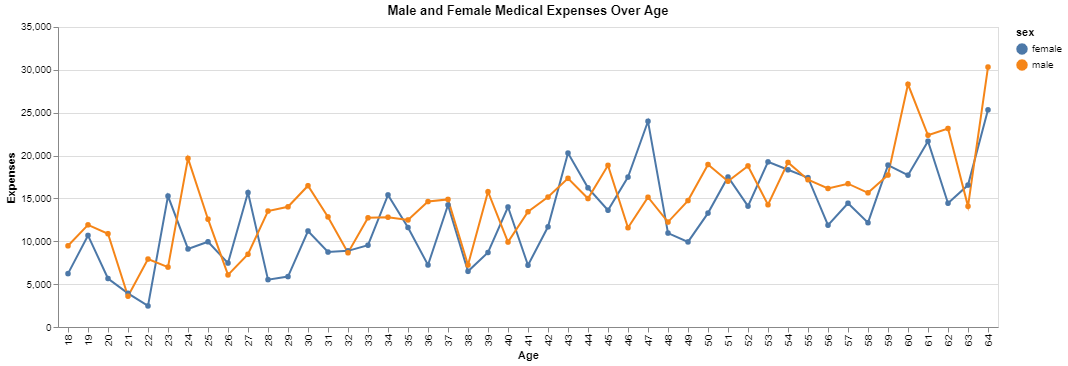

In [18]:
training_df = X_train
training_df['charges'] = y_train


alt.Chart(training_df.groupby(['age','sex']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Expenses'),
    alt.Color('sex:N')
).properties(title='Male and Female Medical Expenses Over Age')

The expenses seem to grow with age for both males and females. There is a peak in the male charges around the age of 60. The increase we noticed before that occurs at the age of 43 happens to both genders. 

**Let's see how smokers and non smokers are spending for medical treatments during their lifetime**

We expect expenditures by smokers should be higher than the non smokers.

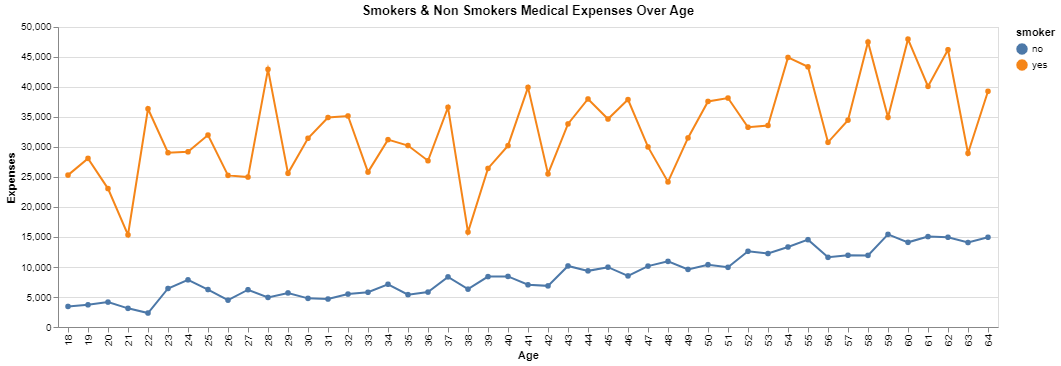

In [19]:
alt.Chart(training_df.groupby(['age','smoker']).mean().reset_index()).mark_line(point = True).encode(
    alt.X('age:N', title = 'Age'),
    alt.Y('charges:Q', title = 'Expenses'),
    alt.Color('smoker:N')
).properties(title='Smokers & Non Smokers Medical Expenses Over Age')

Health expenses of smokers are a lot higher than the one of non-smokers. 

**Let's see how BMI is changing with Age for Males and Females**

We are expecting both male and females have usual BMI.

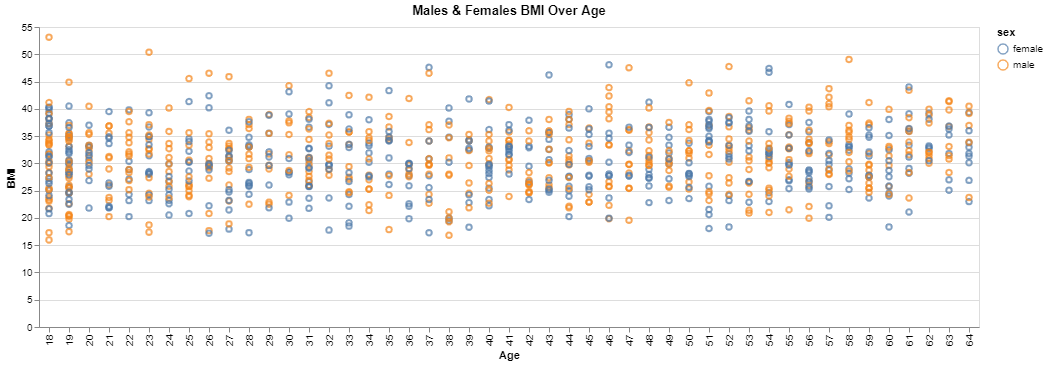

In [20]:
alt.Chart(X_train).mark_point().encode(
    
    alt.X('age:N', title = 'Age'),
    alt.Y('bmi:Q', title = 'BMI'),
    alt.Color('sex:N')
).properties(title='Males & Females BMI Over Age')

The BMI doesn't seem to vary depending on the age nor the sex.

**Let's see how the spending for medical treatments changes regarding to the BMI of a person**

We expect expenditures to be higher for people who have very high BMI.

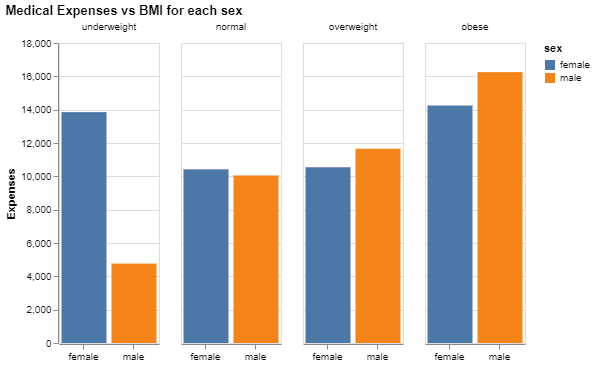

In [21]:
alt.Chart(training_df.groupby(['bmi_cat','sex']).mean().reset_index()).mark_bar().encode(
        alt.X('sex:N', title = '', sort=['underweight', 'normal', 'overweight', 'obese'], axis=alt.Axis(labelAngle=0)),
        alt.Y('charges:Q', title = 'Expenses'),
        alt.Color('sex:N'), 
        alt.Column('bmi_cat:N', sort=['underweight', 'normal', 'overweight', 'obese'], title='')
).properties(title='Medical Expenses vs BMI for each sex', width=100)

The highest expenses seem to occur for people from both genders who are obese. 